# Auxiliary Tests

This notebook contains some tests to probe the behaviour of the used operations.

---

In [192]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import src.wrappers as wrp

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Jacobian-Vector-Product / Gradient Trick

For example consider $\mathbf x = (1, 2, 3) \in \mathbb R^3$ and 
$$
    f: \mathbb R^3 \to \mathbb R, \ x\mapsto x_0^3+x_1^3+x_2^3 + 2x_0x_1x_2\, .
$$
Then Gradient, Hessian, and Hessian-Gradient-Product can be calculated as shown below:

In [193]:
## Testing Tape Behaviour
x = tf.Variable([1., 2., 3.])
with tf.GradientTape(persistent=True) as outer_tape:
    with tf.GradientTape() as tape:
       y = tf.reduce_sum(x ** 3.) + 2*tf.reduce_prod(x)
    grad  = tape.gradient(y, x)
    int_H = tf.reduce_sum(grad * tf.stop_gradient(grad))
hess = outer_tape.jacobian(grad, x)
hess_rowsums = outer_tape.gradient(grad, x)
hess_x_grad = outer_tape.gradient(int_H, x)

print("Gradient:", grad.numpy())
print("Hessian:\n", hess.numpy())
print("Rowsums of Hessian:", hess_rowsums.numpy())
print("Hessian times Gradient Explicitly:\n", 
    tf.matmul([hess], tf.transpose([grad])).numpy().flatten())
print("Hessian times Gradient Implicitly:\n",
    hess_x_grad.numpy())

Gradient: [15. 18. 31.]
Hessian:
 [[ 6.  6.  4.]
 [ 6. 12.  2.]
 [ 4.  2. 18.]]
Rowsums of Hessian: [16. 20. 24.]
Hessian times Gradient Explicitly:
 [322. 368. 654.]
Hessian times Gradient Implicitly:
 [322. 368. 654.]


Instead of using a usual `GradientTape` one can also use a `ForwardAccumulator` which is able of directly calculating jacobina-vector-products and therefore also hessian-gradient-products (see the [docs](https://www.tensorflow.org/api_docs/python/tf/autodiff/ForwardAccumulator)). Yet for doing so, we already need the gradient to pass it as `tangents` to the `ForwardAccumulator`. This is less efficient when having lots of weights.

In [194]:
with tf.autodiff.ForwardAccumulator(x, grad) as acc:
    with tf.GradientTape() as tape:
        y = tf.reduce_sum(x ** 3.) + 2*tf.reduce_prod(x)
    grad2 = tape.gradient(y, x)
print("Hessian-x-Gradient via. `ForwardAccumulator`_\n",
    acc.jvp(grad2).numpy())  # forward-over-backward Hessian-vector product

Hessian-x-Gradient via. `ForwardAccumulator`_
 [322. 368. 654.]


---

## Keras Reproducability

Assessing reproducability in `tf.keras`. The scipt below shows, that the training can be made deterministic to some extent, by setting random seeds. Yet note that with larger learning rates the deviations grow.

In [195]:
## Fetch Mnist-Dataset
np.random.seed(42)
(X_train, y_train), (X_test, y_test) = wrp.load_mnist() # 10000
num_classes = 10
## Pad to LeNet-Input-Shape
X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test  = np.pad(X_test,  ((0,0),(2,2),(2,2),(0,0)), 'constant')
batch_size = 256

In [196]:
def get_model():
    return keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', 
            input_shape=X_train.shape[1:]),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

Generating Model and storing initial weights

In [197]:
model1 = get_model()
loss_fn1 = keras.losses.CategoricalCrossentropy()

In [198]:
w_init = model1.get_weights()
lr = 0.05
steps = np.arange(300)

In [199]:
from importlib import reload
wrp = reload(wrp)

Training Model 1:

In [200]:
## Using a custom loop for full control
tf.random.set_seed(42)
np.random.seed(42)
loss1 = []
for n in steps:
    X_batch, y_batch = wrp.non_random_batch(X_train, y_train, n, batch_size)
    with tf.GradientTape() as inner_tape:
        y_pred = model1(X_batch)
        main_loss = tf.reduce_mean(loss_fn1(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model1.losses)
    gradients = inner_tape.gradient(loss, model1.trainable_weights)
    for w, g in zip(model1.trainable_weights, gradients):
        w.assign(w - lr*g)

    loss1.append(loss.numpy())
    print(f"Step {n+1} -- Loss: {loss1[-1]:.3f}", end="\r")
weights1 = model1.get_weights()

Generating and training Model 2

In [201]:
model2 = keras.models.clone_model(model1)
model2.set_weights(w_init)

In [202]:
## Using a custom loop for full control
tf.random.set_seed(42)
np.random.seed(42)
loss2 = []
for n in steps:
    X_batch, y_batch = wrp.non_random_batch(X_train, y_train, n, batch_size)
    with tf.GradientTape() as inner_tape:
        y_pred = model2(X_batch)
        main_loss = tf.reduce_mean(loss_fn1(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model2.losses)
    gradients = inner_tape.gradient(loss, model2.trainable_weights)
    for w, g in zip(model2.trainable_weights, gradients):
        w.assign(w - lr*g)

    loss2.append(loss.numpy())
    print(f"Step {n+1} -- Loss: {loss1[-1]:.3f}", end="\r")
weights2 = model2.get_weights()

Comparing Weights

In [203]:
print("Mean rel. Deviations:")
mrds = [wrp.mean_rel_diff(w1, w2) for w1, w2 in zip(weights1, weights2)]
_ = [print(f"{mrd:.4f}", end="; ") for mrd in mrds]
print("\nAll Close:")
_ = [print(np.allclose(w1, w2), end="; ") for w1, w2 in zip(weights1, weights2)]

Mean rel. Deviations:
0.0045; 0.4269; 0.0048; 0.1894; 0.0079; 0.0373; 0.0096; 0.0890; 0.0156; 0.0054; 
All Close:
False; False; False; False; False; False; False; False; False; False; 

Comparing Predictions

In [204]:
y_pred1 = np.argmax(model1.predict(X_test), axis=1)
y_pred2 = np.argmax(model2.predict(X_test), axis=1)

np.mean(y_pred1 == y_pred2)

0.9977

Comparing Fit History / Losses

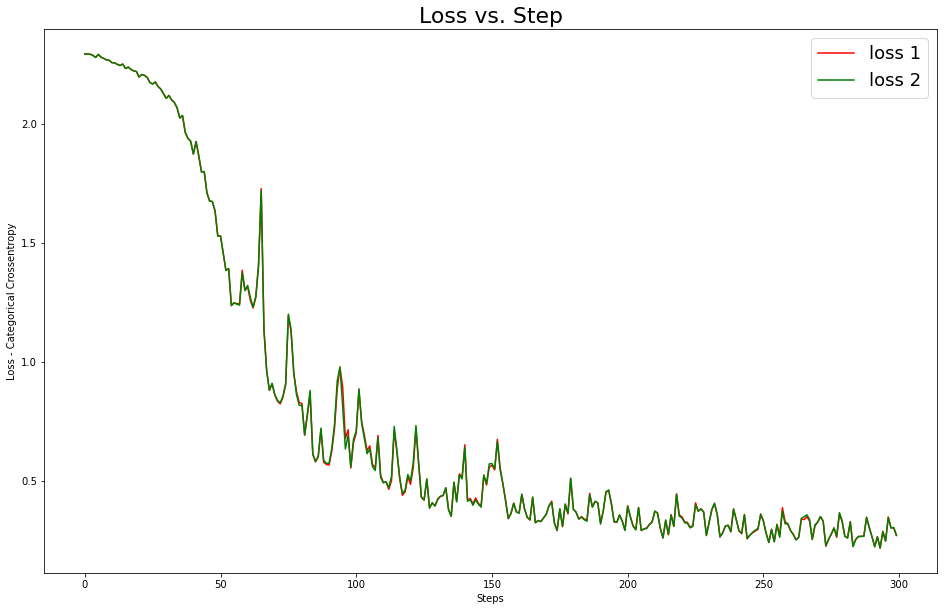

In [205]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Loss vs. Step", fontsize=22)
ax.plot(steps, loss1, "r-",  label="loss 1")
ax.plot(steps, loss2, "g-",  label="loss 2")
ax.set_xlabel("Steps")
ax.set_ylabel("Loss - Categorical Crossentropy")
leg = ax.legend(frameon=True, fontsize=18)